<a href="https://colab.research.google.com/github/OhadHayoun/Movies-system/blob/loren/Collaborative_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install surprise

     |████████████████████████████████| 11.8MB 3.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1618240 sha256=7d5f569f14e0fb74efe4e03e17419198cc915ef92e010c395412a9f51ff951c3
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
! pip install matrix_factorization

     |████████████████████████████████| 22.2MB 63.3MB/s 
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-cp36-none-any.whl size=16468 sha256=e2abba306261a5206be0340428512cce4d7402353b84809c7cc2f2803d5d1f2c
  Stored in directory: /root/.cache/pip/wheels/db/ef/99/19df32b6eb88678b0e3a42d2e24955e7753b2de44615111bad
Successfully built matrix-factorization
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from surprise import Reader, SVD, Dataset
from surprise.model_selection.validation import cross_validate
from matrix_factorization import KernelMF
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
from google.colab import files

uploaded = files.upload()

Saving cleaned_movies.csv to cleaned_movies.csv
Saving ratings.csv to ratings.csv


# EDA and preprocessing

Preprocessing of the movie dataframe has been done in an other notebook. We downloaded here the final dataframe. We will keep rating only for movies that are in the cleaned dataframe. 

The number of ratings per user can vary a lot. However it can be very challenging to predict mivie ratings for users with few ratings. That why we will run our model with different minimum of rating per user and see the impacts on the metrics.

First let do a little EDA on the rating dataframe.

In [5]:
movies_df = pd.read_csv('cleaned_movies.csv')
ratings_df = pd.read_csv('ratings.csv')

In [6]:
movies_df.head(10)

,Unnamed: 0,budget,genres,id,imdb_id,original_title,production_companies,revenue,runtime,spoken_languages,title,vote_count,release_year,cast,keywords,director
0,0,30000000,"['Animation', 'Comedy', 'Family']",862,tt0114709,Toy Story,['Pixar Animation Studios'],373554033.0,81.0,['English'],Toy Story,5415.0,1995,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousy', 'toy', 'boy']",John Lasseter
1,1,65000000,"['Adventure', 'Fantasy', 'Family']",8844,tt0113497,Jumanji,"['TriStar Pictures', 'Teitler Film', 'Intersco...",262797249.0,104.0,"['English', 'Français']",Jumanji,2413.0,1995,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board game', 'disappearance', ""based on chil...",Joe Johnston
2,2,0,"['Romance', 'Comedy']",15602,tt0113228,Grumpier Old Men,"['Warner Bros.', 'Lancaster Gate']",0.0,101.0,['English'],Grumpier Old Men,92.0,1995,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fishing', 'best friend', 'duringcreditssting...",Howard Deutch
3,3,16000000,"['Comedy', 'Drama', 'Romance']",31357,tt0114885,Waiting to Exhale,['Twentieth Century Fox Film Corporation'],81452156.0,127.0,['English'],Waiting to Exhale,34.0,1995,"['Whitney Houston', 'Angela Bassett', 'Loretta...","['based on novel', 'interracial relationship',...",Forest Whitaker
4,4,0,['Comedy'],11862,tt0113041,Father of the Bride Part II,"['Sandollar Productions', 'Touchstone Pictures']",76578911.0,106.0,['English'],Father of the Bride Part II,173.0,1995,"['Steve Martin', 'Diane Keaton', 'Martin Short']","['baby', 'midlife crisis', 'confidence']",Charles Shyer
5,5,60000000,"['Action', 'Crime', 'Drama']",949,tt0113277,Heat,"['Regency Enterprises', 'Forward Pass', 'Warne...",187436818.0,170.0,"['English', 'Español']",Heat,1886.0,1995,"['Al Pacino', 'Robert De Niro', 'Val Kilmer']","['robbery', 'detective', 'bank']",Michael Mann
6,6,58000000,"['Comedy', 'Romance']",11860,tt0114319,Sabrina,"['Paramount Pictures', 'Scott Rudin Production...",0.0,127.0,"['Français', 'English']",Sabrina,141.0,1995,"['Harrison Ford', 'Julia Ormond', 'Greg Kinnear']","['paris', 'brother brother relationship', 'cha...",Sydney Pollack
7,7,0,"['Action', 'Adventure', 'Drama']",45325,tt0112302,Tom and Huck,['Walt Disney Pictures'],0.0,97.0,"['English', 'Deutsch']",Tom and Huck,45.0,1995,"['Jonathan Taylor Thomas', 'Brad Renfro', 'Rac...",[],Peter Hewitt
8,8,35000000,"['Action', 'Adventure', 'Thriller']",9091,tt0114576,Sudden Death,"['Universal Pictures', 'Imperial Entertainment...",64350171.0,106.0,['English'],Sudden Death,174.0,1995,"['Jean-Claude Van Damme', 'Powers Boothe', 'Do...","['terrorist', 'hostage', 'explosive']",Peter Hyams
9,9,58000000,"['Adventure', 'Action', 'Thriller']",710,tt0113189,GoldenEye,"['United Artists', 'Eon Productions']",352194034.0,130.0,"['English', 'Pусский', 'Español']",GoldenEye,1194.0,1995,"['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...","['cuba', 'falsely accused', 'secret identity']",Martin Campbell


In [7]:
movies_df.shape

(29424, 16)

In [8]:
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [9]:
ratings_df.shape

(100836, 4)

### Merge ratings and movie table to get the movie title in the same table

In [56]:
df=ratings_df.merge(movies_df[['id','original_title']],how='inner', left_on='movieId', right_on='id')
df.head(10)

,userId,movieId,rating,timestamp,id,original_title
0,1,6,4.0,964982224,6,Judgment Night
1,6,6,4.0,845553757,6,Judgment Night
2,11,6,5.0,902154266,6,Judgment Night
3,18,6,4.0,1460138360,6,Judgment Night
4,23,6,4.0,1107342267,6,Judgment Night
5,24,6,4.5,1458941767,6,Judgment Night
6,28,6,3.5,1234570483,6,Judgment Night
7,32,6,3.0,856736172,6,Judgment Night
8,44,6,3.0,869251910,6,Judgment Night
9,45,6,4.0,1121724608,6,Judgment Night


In [11]:
df.shape

(28643, 6)

### Remove duplicate

In [12]:
df = df.drop_duplicates()

### Number of ratings per user distribution


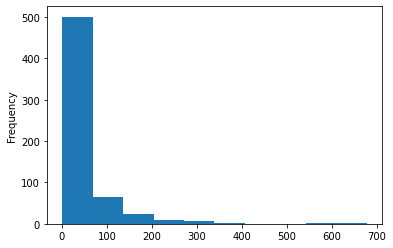

In [13]:
df['userId'].value_counts().plot(kind='hist')

Let's zoom on less that 100 ratings per user

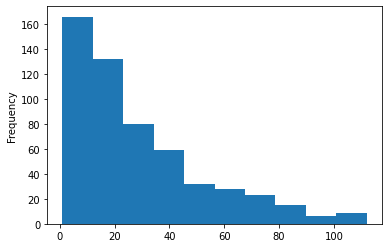

In [64]:
df['userId'].value_counts()[-550:].plot(kind='hist')

# Modeling

We will run two different matrix factorization models/packages with 4 different minimum of rating per user. Then we will chose our best option. Finally, we will hypertune the parameters of this best option.

In [66]:
df['count']=df['userId'].map(df['userId'].value_counts())
df = df.rename(columns={"userId":"user_id", "movieId":"item_id"})
df_10 = df[df['count']>10]
df_5 = df[df['count']>5]
df_50 = df[df['count']>50]
df_20 = df[df['count']>20]

## Min 10 ratings

### Matrix factorization

In [15]:
X = df_10[['user_id','item_id']]
y = df_10['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_10['user_id'])

In [16]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0097692769027926
Epoch  2 / 200  -  train_rmse: 0.9859376040488397
Epoch  3 / 200  -  train_rmse: 0.9671377243398298
Epoch  4 / 200  -  train_rmse: 0.9516896757284785
Epoch  5 / 200  -  train_rmse: 0.9386647880040009
Epoch  6 / 200  -  train_rmse: 0.9274274858301409
Epoch  7 / 200  -  train_rmse: 0.917557788863334
Epoch  8 / 200  -  train_rmse: 0.90877414612245
Epoch  9 / 200  -  train_rmse: 0.9008595021043035
Epoch  10 / 200  -  train_rmse: 0.8936626037113307
Epoch  11 / 200  -  train_rmse: 0.8870615903692008
Epoch  12 / 200  -  train_rmse: 0.8809550069178345
Epoch  13 / 200  -  train_rmse: 0.8752682949741389
Epoch  14 / 200  -  train_rmse: 0.8699441299543921
Epoch  15 / 200  -  train_rmse: 0.8649291753938464
Epoch  16 / 200  -  train_rmse: 0.8601842987616585
Epoch  17 / 200  -  train_rmse: 0.8556740454557074
Epoch  18 / 200  -  train_rmse: 0.8513719896513736
Epoch  19 / 200  -  train_rmse: 0.8472547576377235
Epoch  20 / 200  -  train_rmse: 0.843301920

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [ ]:
# matrix_fact.update_users(X_train_update, y_train_update, lr=0.001, n_epochs=200, verbose=1)

In [17]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_10 = (rmse, r2)
metrics_mf_10

(0.8950978955531211, 0.26141001981150913)

### SVD

In [18]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [19]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [20]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (1.0462188720703125,
  1.0407946109771729,
  1.0379910469055176,
  1.0403344631195068,
  1.0419740676879883),
 'test_mae': array([0.68969644, 0.6779366 , 0.66425585, 0.69665985, 0.67060875]),
 'test_rmse': array([0.89060697, 0.87876678, 0.85958975, 0.90098413, 0.86908264]),
 'test_time': (0.029440879821777344,
  0.0298769474029541,
  0.03436636924743652,
  0.03490328788757324,
  0.02949380874633789)}

In [21]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [22]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_10 = (rmse, r2)
metrics_svd_10

(0.8720290051297501, 0.298990020506852)

## Min 5 ratings
### Matrix factorization

In [23]:
X = df_5[['user_id','item_id']]
y = df_5['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_5['user_id'])

In [24]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.018393496490056
Epoch  2 / 200  -  train_rmse: 0.9941300128921118
Epoch  3 / 200  -  train_rmse: 0.9749761055541682
Epoch  4 / 200  -  train_rmse: 0.9592800451762725
Epoch  5 / 200  -  train_rmse: 0.9460637548823242
Epoch  6 / 200  -  train_rmse: 0.9346734033534353
Epoch  7 / 200  -  train_rmse: 0.9247096916677188
Epoch  8 / 200  -  train_rmse: 0.9158485983126458
Epoch  9 / 200  -  train_rmse: 0.9078734706448968
Epoch  10 / 200  -  train_rmse: 0.9006185306327217
Epoch  11 / 200  -  train_rmse: 0.8939525287939899
Epoch  12 / 200  -  train_rmse: 0.8877977711009599
Epoch  13 / 200  -  train_rmse: 0.882059943709681
Epoch  14 / 200  -  train_rmse: 0.876681271895596
Epoch  15 / 200  -  train_rmse: 0.8716103686473956
Epoch  16 / 200  -  train_rmse: 0.8668091354997001
Epoch  17 / 200  -  train_rmse: 0.8622429899857682
Epoch  18 / 200  -  train_rmse: 0.8578826594920963
Epoch  19 / 200  -  train_rmse: 0.8537103722118088
Epoch  20 / 200  -  train_rmse: 0.849695902

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [26]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_5 = (rmse, r2)
metrics_mf_5

(0.8874538602069754, 0.24574117875822954)

### SVD

In [27]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [28]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [29]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (1.0789992809295654,
  1.0861120223999023,
  1.070850133895874,
  1.0710537433624268,
  1.092087745666504),
 'test_mae': array([0.69306416, 0.67887076, 0.68543678, 0.67886064, 0.67377209]),
 'test_rmse': array([0.88813678, 0.88565358, 0.88574782, 0.8786867 , 0.87339793]),
 'test_time': (0.029689788818359375,
  0.029695510864257812,
  0.03066873550415039,
  0.029462814331054688,
  0.13886594772338867)}

In [30]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [31]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_5 = (rmse, r2)
metrics_svd_5

(0.8681151628159886, 0.2782554451201248)

## Min 50 ratings
### Matrix factorization

In [32]:
X = df_50[['user_id','item_id']]
y = df_50['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_50['user_id'])

In [33]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 0.9934537456793572
Epoch  2 / 200  -  train_rmse: 0.9706451544254855
Epoch  3 / 200  -  train_rmse: 0.952496848968677
Epoch  4 / 200  -  train_rmse: 0.9374270555747118
Epoch  5 / 200  -  train_rmse: 0.9245544835394549
Epoch  6 / 200  -  train_rmse: 0.913366775462427
Epoch  7 / 200  -  train_rmse: 0.9034710219127691
Epoch  8 / 200  -  train_rmse: 0.8946374820821914
Epoch  9 / 200  -  train_rmse: 0.8866719575718014
Epoch  10 / 200  -  train_rmse: 0.8794191050381548
Epoch  11 / 200  -  train_rmse: 0.8727619540755759
Epoch  12 / 200  -  train_rmse: 0.8666252259270801
Epoch  13 / 200  -  train_rmse: 0.8609214261387912
Epoch  14 / 200  -  train_rmse: 0.8555917396799846
Epoch  15 / 200  -  train_rmse: 0.8505856845343692
Epoch  16 / 200  -  train_rmse: 0.8458621998910129
Epoch  17 / 200  -  train_rmse: 0.8413843659834136
Epoch  18 / 200  -  train_rmse: 0.8371222937462954
Epoch  19 / 200  -  train_rmse: 0.8330471861636128
Epoch  20 / 200  -  train_rmse: 0.82914228

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [34]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_50 = (rmse, r2)
metrics_mf_50

(0.8759059646560083, 0.2607238338671506)

### SVD

In [35]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [36]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [37]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (0.7501652240753174,
  0.7396395206451416,
  0.7526743412017822,
  0.739271879196167,
  0.7426507472991943),
 'test_mae': array([0.66316547, 0.64735975, 0.66406549, 0.66815602, 0.67214552]),
 'test_rmse': array([0.84915254, 0.8350642 , 0.86350757, 0.86175243, 0.87772264]),
 'test_time': (0.020007848739624023,
  0.019824981689453125,
  0.02038264274597168,
  0.020375728607177734,
  0.020493268966674805)}

In [38]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [39]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_50 = (rmse, r2)
metrics_svd_50

(0.8509081934112404, 0.3023185943410709)

## Min 20 ratings
### Matrix factorization

In [40]:
df_20 = df[df['count']>20]
X = df_20[['user_id','item_id']]
y = df_20['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

In [41]:
matrix_fact = KernelMF(n_epochs=200, n_factors=100, lr=0.001, reg=0.005)
matrix_fact.fit(X_train, y_train)

Epoch  1 / 200  -  train_rmse: 1.0097755195477756
Epoch  2 / 200  -  train_rmse: 0.9862413096100611
Epoch  3 / 200  -  train_rmse: 0.9674694098785414
Epoch  4 / 200  -  train_rmse: 0.9519156649258809
Epoch  5 / 200  -  train_rmse: 0.9386754906740331
Epoch  6 / 200  -  train_rmse: 0.927206072877405
Epoch  7 / 200  -  train_rmse: 0.9171115732223618
Epoch  8 / 200  -  train_rmse: 0.9081091443359877
Epoch  9 / 200  -  train_rmse: 0.8999966448948569
Epoch  10 / 200  -  train_rmse: 0.8926232546619011
Epoch  11 / 200  -  train_rmse: 0.8858628738870152
Epoch  12 / 200  -  train_rmse: 0.8796216498645244
Epoch  13 / 200  -  train_rmse: 0.8738168405116647
Epoch  14 / 200  -  train_rmse: 0.868382315918251
Epoch  15 / 200  -  train_rmse: 0.8632722242112818
Epoch  16 / 200  -  train_rmse: 0.8584417389624883
Epoch  17 / 200  -  train_rmse: 0.8538610678909516
Epoch  18 / 200  -  train_rmse: 0.8494952981515524
Epoch  19 / 200  -  train_rmse: 0.8453208724087588
Epoch  20 / 200  -  train_rmse: 0.84131572

KernelMF(gamma=0.01, lr=0.001, n_epochs=200, reg=0.005)

In [42]:
pred = matrix_fact.predict(X_test)
# pred = [round(x) for x in pred]
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
metrics_mf_20 = (rmse, r2)
metrics_mf_20

(0.8969691818247627, 0.24809833036344675)

### SVD

In [43]:
df_train =  pd.concat([X_train, y_train], axis=1)

In [44]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)

In [45]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE','MAE'])

{'fit_time': (0.9738905429840088,
  0.9584827423095703,
  0.9611325263977051,
  0.9558393955230713,
  0.9605276584625244),
 'test_mae': array([0.67609544, 0.68735323, 0.67061926, 0.67464102, 0.67682541]),
 'test_rmse': array([0.87373538, 0.88660735, 0.86201826, 0.87315558, 0.88176517]),
 'test_time': (0.026323795318603516,
  0.026943683624267578,
  0.025992870330810547,
  0.02635788917541504,
  0.02594137191772461)}

In [46]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [47]:
y_pred = []
for line in range(len(X_test)):
  y_pred.append(svd.predict(X_test.iloc[line,0],X_test.iloc[line,1],3)[3])
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
metrics_svd_20 = (rmse, r2)
metrics_svd_20

(0.8721512945324089, 0.2891308534765916)

## Model Selection

In [48]:
mins = [5,5,10,10,50,50,20,20]
methods = [0,1,0,1,0,1,0,1]
metrics = [metrics_mf_5,metrics_svd_5,metrics_mf_10, metrics_svd_10, metrics_mf_50, metrics_svd_50,metrics_mf_20, metrics_svd_20 ]
rmses = []
r2s = []
for met in metrics:
  rmses.append(met[0])
  r2s.append(met[1])

In [49]:
rmses

[0.8874538602069754,
 0.8681151628159886,
 0.8950978955531211,
 0.8720290051297501,
 0.8759059646560083,
 0.8509081934112404,
 0.8969691818247627,
 0.8721512945324089]

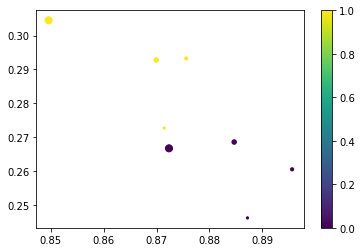

In [ ]:
plt.scatter(x=rmses, y=r2s, s=mins, c=methods)
plt.colorbar()

We want to maximize R2 and minimize RMSE. So we want the most left upper corner point!

First, the SVD matrix factorization - yellow points- returns better metrics, we will use this package.

Concerning the minimum of rating per users, limited users with more than 50 ratings is too much, we will lose to many data. Let use the SVD model with minimum number of 20 and try to tune its hyperparameters. 

Let know hypertune the parameters of this model.

## Hyperparameters of SVD with 20 min user ratings

We will hypertune the number of factors, epochs and learning rate.

In [50]:
df_20 = df[df['count']>20]

df_train, df_test = train_test_split(df_20, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

In [51]:
factors = [100,200,500]
epochs = [20,50,100]
lr_all = [0.001,0.005,0.01]

In [52]:
reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
rmse_20 = []
r2_20 = []
params = []
for fac in factors:
  for epoch in epochs:
    for lr in lr_all:
      svd = SVD(n_factors=fac, n_epochs=epoch, lr_all=lr)
      cross_validate(svd, data, measures=['RMSE','MAE'])
      trainset = data.build_full_trainset()
      svd.fit(trainset)
      y_pred = []
      for line in range(len(df_test)):
        y_pred.append(svd.predict(df_test.iloc[line,0],df_test.iloc[line,1],3)[3])
      rmse_20.append(mean_squared_error(df_test['rating'], y_pred, squared=False))
      r2_20.append(r2_score(df_test['rating'], y_pred))
      params.append((fac,epoch,lr))



In [53]:
np.argmin(rmse_20), np.argmax(r2_20), params[np.argmin(rmse_20)]

(26, 26, (500, 100, 0.01))

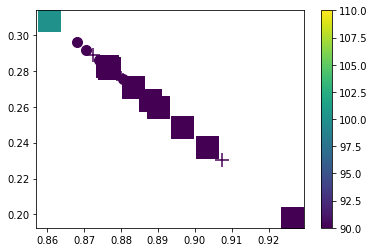

In [54]:
factors_plt = [100,100,100,100,100,100,100,100,100,200,200,200,200,200,200,200,200,200,500,500,500,500,500,500,500,500,500]
epochs_plt = [20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100,20,20,20,50,50,50,100,100,100]
marker_plt = ['o','o','o','o','o','o','o','o','o','+','+','+','+','+','+','+','+','+','s','s','s','s','s','s','s','s','s']
for _m, c, _s, _x, _y in zip(marker_plt, epochs_plt, factors_plt, rmse_20, r2_20):
    plt.scatter(_x, _y, marker=_m, c=c, s=_s)
# plt.scatter(x=rmse_20, y=r2_20, s=factors_plt, c=epochs_plt, marker=marker_plt)
plt.colorbar()

Again, we want to most left upper point. The best option is the default one: n_factors=500, epochs=100 and learning rate=0.01

## Get 10 best reco

In [67]:
df_20 = df[df['count']>20]

df_train, df_test = train_test_split(df_20, test_size=0.20, \
                                                    random_state=1000, \
                                    stratify = df_20['user_id'])

reader = Reader()
data = Dataset.load_from_df(df_train[['user_id', 'item_id', 'rating']], reader)
svd = SVD(n_factors=500, n_epochs=100, lr_all=0.01)
cross_validate(svd, data, measures=['RMSE','MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)

In [80]:
def get_10(user_id, top_n=10):
  movies_id = df_20['item_id'].unique().tolist()
  movie_rates = [(id, svd.predict(user_id, id)[3]) for id in movies_id]#
  movie_rates = sorted(movie_rates, key=lambda x:x[1], reverse=True)
  return dict(movie_rates[:top_n])



In [81]:
get_10(1)

{475: 5,
 745: 5,
 750: 4.991575260118308,
 923: 5,
 924: 4.998327374974078,
 1250: 4.983823533247983,
 1278: 5,
 2067: 5,
 2502: 5,
 8874: 5}